# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.


Для начала загрузим и изучим данные: рассмотрим дубликаты, пропуски, разберемся с регистром и лишними знаками в тектах и избавимся от стоп-слов. Далее приступим к разделу обучения: разделим данные на выборки, проведем TF-IDF векторизацию, обучим модели, подбирая различные параметры и вычисляя метрику F1.

## Подготовка

In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
import re
from pymystem3 import Mystem
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    data = pd.read_csv('/datasets/toxic_comments.csv')
except:
    data = pd.read_csv('C:/Downloads/toxic_comments.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


Пропусков не наблюдается, видим непонятный стобец `Unnamed: 0`.

In [4]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


Удалим этот столбец

In [5]:
data = data.drop('Unnamed: 0', axis=1)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Рассмотрим дубликаты

In [7]:
data.duplicated().sum()

0

И еще раз перепроверим пропуски

In [8]:
data.isna().sum()

text     0
toxic    0
dtype: int64

Рассмотрим подробнее текста

In [9]:
data.text

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159287    ":::::And for the second time of asking, when ...
159288    You should be ashamed of yourself \n\nThat is ...
159289    Spitzer \n\nUmm, theres no actual article for ...
159290    And it looks like it was actually you who put ...
159291    "\nAnd ... I really don't think you understand...
Name: text, Length: 159292, dtype: object

Видим лишние знаки, различный регистр. Применим регулярные выражения для избаления от этого.

In [10]:
def cleaning(text):
    text = re.sub(r"(?:\n|\r)", " ", text)
    text = re.sub(r"[^a-zA-Z ]+", "", text).strip()
    text = text.lower()
    return text

data['text'] = data['text'].apply(cleaning)

In [11]:
data.text

0         explanation why the edits made under my userna...
1         daww he matches this background colour im seem...
2         hey man im really not trying to edit war its j...
3         more i cant make any real suggestions on impro...
4         you sir are my hero any chance you remember wh...
                                ...                        
159287    and for the second time of asking when your vi...
159288    you should be ashamed of yourself   that is a ...
159289    spitzer   umm theres no actual article for pro...
159290    and it looks like it was actually you who put ...
159291    and  i really dont think you understand  i cam...
Name: text, Length: 159292, dtype: object

Проведем лемматизацию текстов

In [12]:
corpus = list(data['text'])

In [13]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [15]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [16]:
from nltk.corpus import wordnet
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [19]:
from tqdm.notebook import tqdm

In [20]:
%%time
def lemmafunction(textc):
    k=[]
    for i in nltk.word_tokenize(textc):
        y=lemmatizer.lemmatize(i, get_wordnet_pos(i))
        k.append(y)
    return ' '.join(k) 

lemy=[]
for i in tqdm(range(len(corpus))):
    
    lemy.append(lemmafunction(corpus[i]))
data['lemm_text']=pd.Series(lemy, index=data.index)

  0%|          | 0/159292 [00:00<?, ?it/s]

CPU times: user 15min 17s, sys: 1min 32s, total: 16min 50s
Wall time: 17min 12s


In [25]:
data['text'][5]

'congratulations from me as well use the tools well  talk'

In [26]:
data['lemm_text'][5]

'congratulation from me a well use the tool well talk'

Избавимся от стоп-слов

In [27]:
stopwords = set(nltk_stopwords.words('english'))

### Вывод

В данном разделе были загружены и изучены данные. В данных не обнаружилось дубликатов и пропусков. Были удалены лишние столбцы, знаки в текстах, а также исправлен регистр букв. Проведена лемматизация текстов и избавление от стоп-слов.

## Обучение

Разделим данные на обущающую и тестовую выборки. Целевой признак - `toxic`

In [28]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

features_train = train['text']
target_train = train['toxic']
features_test = test['text']
target_test = test['toxic']

In [29]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(143362,)
(15930,)
(143362,)
(15930,)


Проведем TF-IDF векторизацию

In [30]:
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
tfidf_train = count_tf_idf.fit_transform(features_train)
tfidf_test = count_tf_idf.transform(features_test)

**Логистическая регрессия**

In [31]:
param = {'penalty': ['l1', 'l2'], 'solver': ['liblinear'], 'class_weight': ['balanced']}
model_lr = LogisticRegression(random_state=12345)
tuning_model_lr=GridSearchCV(model_lr, param, scoring='f1', cv=3)
tuning_model_lr.fit(tfidf_train, target_train)

GridSearchCV(cv=3, estimator=LogisticRegression(random_state=12345),
             param_grid={'class_weight': ['balanced'], 'penalty': ['l1', 'l2'],
                         'solver': ['liblinear']},
             scoring='f1')

In [32]:
lr_param = tuning_model_lr.best_params_
lr_score = tuning_model_lr.best_score_
print(lr_param)
print(lr_score)

{'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}
0.7507237626937459


**Случаный лес**

In [33]:
param = {'n_estimators': list(range(50,300,50)), 'max_depth':[5,15]}
model_rf = RandomForestClassifier(random_state=12345)
tuning_model_rf=GridSearchCV(model_rf, param, scoring='f1', cv=3)
tuning_model_rf.fit(tfidf_train, target_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=12345),
             param_grid={'max_depth': [5, 15],
                         'n_estimators': [50, 100, 150, 200, 250]},
             scoring='f1')

In [34]:
rf_param = tuning_model_rf.best_params_
rf_score = tuning_model_rf.best_score_
print(rf_param)
print(rf_score)

{'max_depth': 15, 'n_estimators': 100}
0.0001374287088572803


**Дерево решений**

In [35]:
param = {'max_depth': list(range(30,51,2)), 'class_weight':['balanced']}
model_dt = DecisionTreeClassifier(random_state=12345)
tuning_model_dt=GridSearchCV(model_dt, param, scoring='f1', cv=3)
tuning_model_dt.fit(tfidf_train, target_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=12345),
             param_grid={'class_weight': ['balanced'],
                         'max_depth': [30, 32, 34, 36, 38, 40, 42, 44, 46, 48,
                                       50]},
             scoring='f1')

In [36]:
dt_param = tuning_model_dt.best_params_
dt_score = tuning_model_dt.best_score_
print(dt_param)
print(dt_score)

{'class_weight': 'balanced', 'max_depth': 50}
0.6169844099768603


**SGDCClassifier**

In [37]:
param = {'loss':['hinge', 'log', 'modified_huber'], 'learning_rate':['constant', 'optimal', 'invscaling', 'adaptive'],
                'eta0':[0.01, 0.05, 0.1, 0.2, 0.3, 0.5], 'class_weight':['balanced']}
model_sgd = SGDClassifier(random_state=12345)
tuning_model_sgd=GridSearchCV(model_sgd, param, scoring='f1', cv=3)
tuning_model_sgd.fit(tfidf_train, target_train)

GridSearchCV(cv=3, estimator=SGDClassifier(random_state=12345),
             param_grid={'class_weight': ['balanced'],
                         'eta0': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5],
                         'learning_rate': ['constant', 'optimal', 'invscaling',
                                           'adaptive'],
                         'loss': ['hinge', 'log', 'modified_huber']},
             scoring='f1')

In [38]:
sgd_param = tuning_model_sgd.best_params_
sgd_score = tuning_model_sgd.best_score_
print(sgd_param)
print(sgd_score)

{'class_weight': 'balanced', 'eta0': 0.05, 'learning_rate': 'adaptive', 'loss': 'modified_huber'}
0.754209645528686


## Выводы

Лучшей моделью по метрике F1 оказалась SGDCClassifer со значением F1 = 0.754. 

Проведем тестирование лучшей модели.

In [54]:
model = SGDClassifier(random_state=12345, class_weight='balanced', eta0=0.05, learning_rate='adaptive', loss='modified_huber')
model.fit(tfidf_train, target_train)
prediction = model.predict(tfidf_test)
f1_score(target_test, prediction)

0.7566550147889218

Также рассчитаем метрику AUC-score и построим ROC-кривую.

In [49]:
def plot_roc_curve(fpr, tpr):
    plt.figure(figsize=[15,9])
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [55]:
pred = model.predict_proba(tfidf_test)

In [56]:
auc = roc_auc_score(target_test, pred[:,1])
print('AUC: %.2f' % auc)

AUC: 0.97


In [57]:
fpr, tpr, thresholds = roc_curve(target_test, pred[:,1])

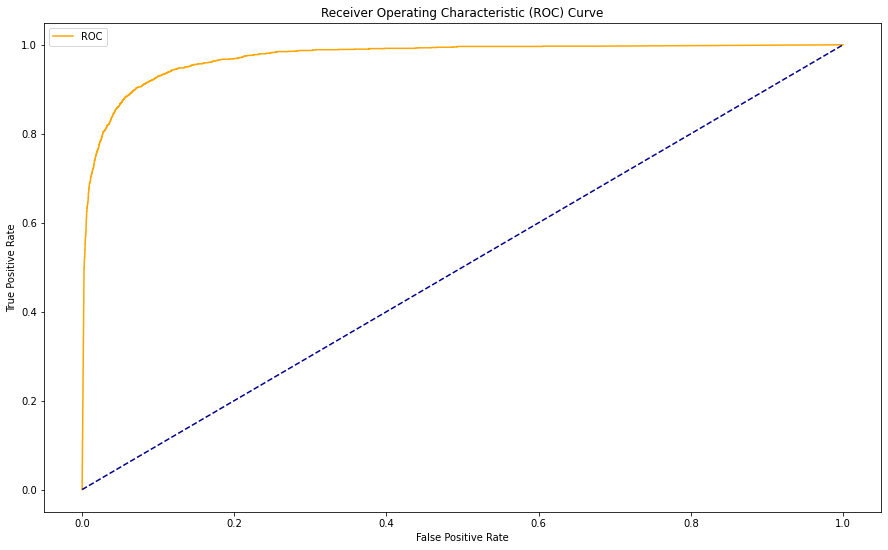

In [58]:
plot_roc_curve(fpr, tpr)

Для данного проекта были получены данные с разметкой о токсичности правок. Необходимо было обучите модель классифицировать комментарии на позитивные и негативныес метрикой F1 не меньше 0.75.

На первом этапе были загружены данные, проверены дубликаты и пропуски, текст в данных был переведен в одинаковый регистр, лишние знаки были удалены, проведена лемматизация текста, а также были удалены стоп-слова.

На втором этапе были проверены 4 модели с подобранными гиперпараметрами: Логистическая регрессия, Случайный лес, Дерево решений и SGDClassifier. Лучшей моделью оказалась SGDClassifier со значением F1 на тесте 0.757